# AG News Classification
Today we will start our first mini-project: a news classification model! We will be using the 'ag_news' dataset, whose associated task is to decide the kind of news ('World','Sports', 'Business', or 'Sci/Tech') only from the news descriptions. Luckily, this dataset is in Hugging Face.

In [1]:
from datasets import load_dataset
news = load_dataset('sh0416/ag_news')

/home/hlovisie/venvs/torch-cuda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let us give a peak on what this dataset looks like.

In [2]:
import random

len_train = news['train'].num_rows
idx = random.randint(0, len_train - 1)

label_map = {'1': 'World', '2': 'Sports', '3': 'Business', '4': 'Sci/Tech'}
print('Text:', news['train']['description'][idx]) 
print('Label:', label_map[str(news['train']['label'][idx])])

Text: Shane Warne expressed concern yesterday that the new proposal on cricket #39;s  quot;chucking quot; controversy might create more confusion.
Label: Sports


Nice, so we have a few questions that we need to adress from now on. The first is, how balanced is the dataset. Let us check that but, in the process, create a new column with the dataset labels explicitly given, instead of the tokenized version.

In [3]:
def labeler(example):
    return label_map[str(example)]

def explicit_label(examples):
    return {'explicit_label': list(map(labeler, examples['label']))}

news = news.map(explicit_label, batched = True)

Now let us check the balance.

In [4]:
from collections import Counter

counts = Counter(news['train']['explicit_label'])
print('Train:', counts)

counts = Counter(news['test']['explicit_label'])
print('Test:', counts)

Train: Counter({'Business': 30000, 'Sci/Tech': 30000, 'Sports': 30000, 'World': 30000})
Test: Counter({'Business': 1900, 'Sci/Tech': 1900, 'Sports': 1900, 'World': 1900})


Perfectly balanced!

We will need a validation dataset to fine-tune both our classical benchmark methods and the transformers. We will work on making one right now.

In [5]:
from datasets import DatasetDict
news_train = news['train']
news_train = news_train.train_test_split(test_size=0.1, seed=42)

news = DatasetDict({
    'train': news_train['train'],
    'validation': news_train['test'],
    'test': news['test']
})

In [6]:
counts = Counter(news['train']['explicit_label'])
print('Train:', counts)

counts = Counter(news['validation']['explicit_label'])
print('Validation:', counts)

Train: Counter({'Business': 27100, 'World': 26991, 'Sports': 26966, 'Sci/Tech': 26943})
Validation: Counter({'Sci/Tech': 3057, 'Sports': 3034, 'World': 3009, 'Business': 2900})


Approximately balances, so we are good to go.

# Benchmark models

We will be using some simpler models to benchmark our transformers. We will use a TF-IDF embedding for that, so let us first initialize it.

## TF-IDF

In [7]:
# I'll just strip the text and remove lower cap everything
# We also remove weird punctuation
# This is particularly important for sparse methods
# Stop word removal will already been taken care by the vectorizer
# We note that it is possible to do this using the sklearn TF-IDF vectorizer 
# directly, but this is a nice opportunity to show the re library
import re
def preprocess_tf_id(text):
    return re.sub(r"\s+", " ", re.sub(r"[^\w\s]", "", text.lower().strip()))
print('Original:', news['train']['description'][0])
print('Preprocessed:', preprocess_tf_id(news['train']['description'][0]))

# Appply preprocessing for the whole batch of texts
def process_batch(list_texts):
    return list(map(preprocess_tf_id, list_texts))

train_texts = process_batch(news['train']['description'])
val_texts = process_batch(news['validation']['description'])
test_texts = process_batch(news['test']['description'])

Original:  BESLAN, Russia (Reuters) - The killing of more than 320  children, parents and teachers during the bloody end to a  53-hour school siege left barely a family untouched in the  small Russian town of Beslan.
Preprocessed: beslan russia reuters the killing of more than 320 children parents and teachers during the bloody end to a 53hour school siege left barely a family untouched in the small russian town of beslan


Finally, we vectorize.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = 'english',  max_features = 10000)
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)
X_test = vectorizer.transform(test_texts)
y_train = news['train']['label']
y_val = news['validation']['label']
y_test = news['test']['label']

Let us visualize whether the data looks separable when projected to dimension 2 using PCA. We will use only the validation set for this.

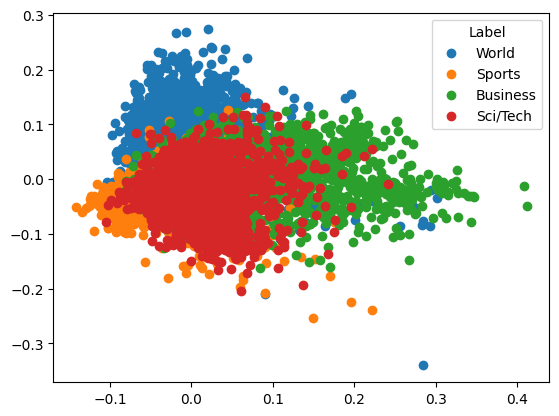

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X_val_pca = pca.fit_transform(X_val)

labels = news["validation"]["label"]
unique_labels = np.unique(labels)

for lab in unique_labels:
    idx = labels == lab
    plt.scatter(
        X_val_pca[idx, 0],
        X_val_pca[idx, 1],
        label = labeler(lab)
    )

plt.legend(title = "Label")
plt.show()

So, no clear separation pattern here. Of course, this does not mean much, but at least seems to suggest that some of the 'World' news are very separated from 'Business'. We will check that once we train models.

## Logistic regression
Since we are using TF-IDF, we will start with logistic regression as our first benchmark (naive bayes is more appropriate for bag-of-words or one-hot encodings). This is a regularizer parameter `C`, which we will find a best value through grid-search.

In [10]:
from sklearn.linear_model import LogisticRegression
best_val_error = -np.inf
best_c = np.inf
for c in [0.01, 0.1, 1, 10, 100]:
    log_reg_c = LogisticRegression(C = c, max_iter = 100)
    log_reg_c.fit(X_train, y_train)
    val_error = log_reg_c.score(X_val, y_val)
    print(f'Validation error @{c:}: {val_error:.2f}')
    if val_error > best_val_error:
        best_val_error =  val_error
        best_c = c

Validation error @0.01: 0.87
Validation error @0.1: 0.89


/home/hlovisie/venvs/torch-cuda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation error @1: 0.90


/home/hlovisie/venvs/torch-cuda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation error @10: 0.89
Validation error @100: 0.89


/home/hlovisie/venvs/torch-cuda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Great, it seems that at `C` equal 1 we get the best results. Let us see the test accuracy at this level. We will save it in a JSON file so we can compare overall accuracy at the end between all models without, necessarily, needing to rerun the full notebook.

In [11]:
log_reg = LogisticRegression(C = 1, max_iter = 100)
log_reg.fit(X_train, y_train)
test_error_log_reg = log_reg.score(X_test, y_test)
print(f'Accuracy of logistic regression {test_error_log_reg: .2f}')

import json
filename = 'best_models_ag_news.json'

error_dic = {'Logistic Regression': test_error_log_reg}
with open(filename, "w") as f:
    json.dump(error_dic, f, indent = 2)

Accuracy of logistic regression  0.90


/home/hlovisie/venvs/torch-cuda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Now that we are here, let us give a look at the confusion matrix.

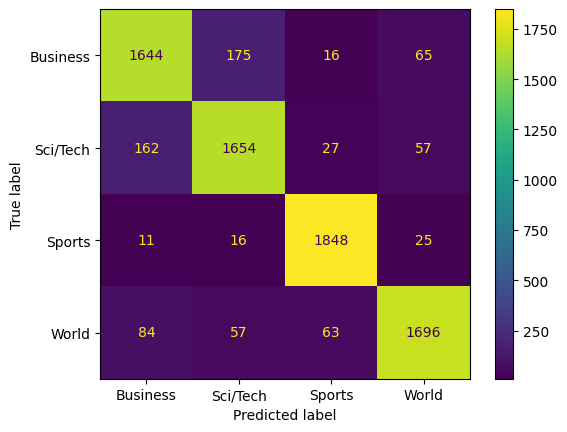

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
_ = ConfusionMatrixDisplay.from_predictions(list(map(labeler, y_test)), list(map(labeler, log_reg.predict(X_test))))

It seems that business is tech are the most confused classes. This, of course, makes sense :p Let us look at the most important features for each class.

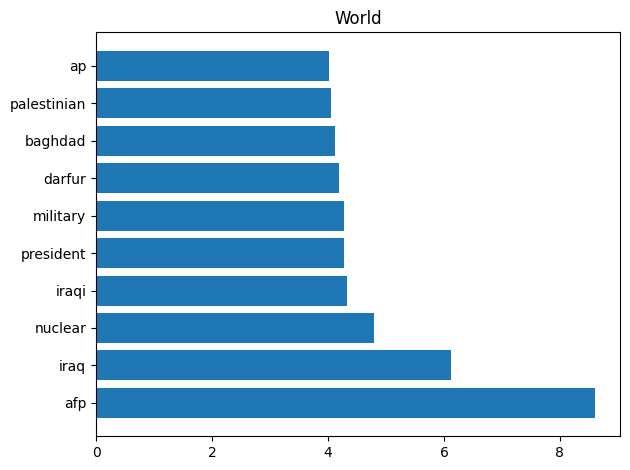

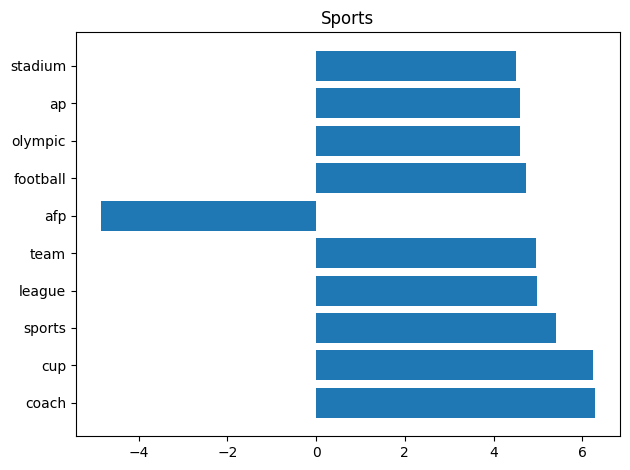

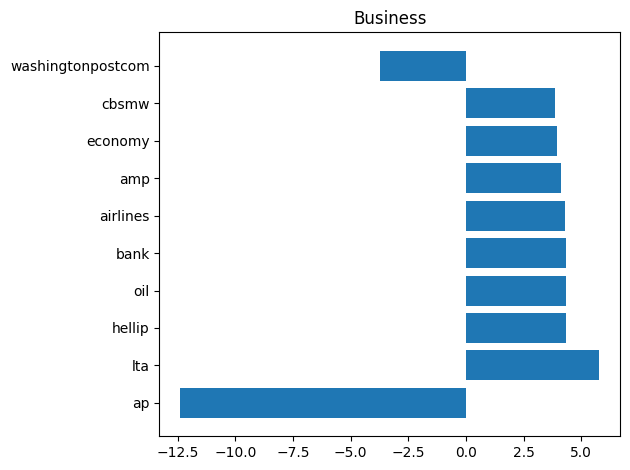

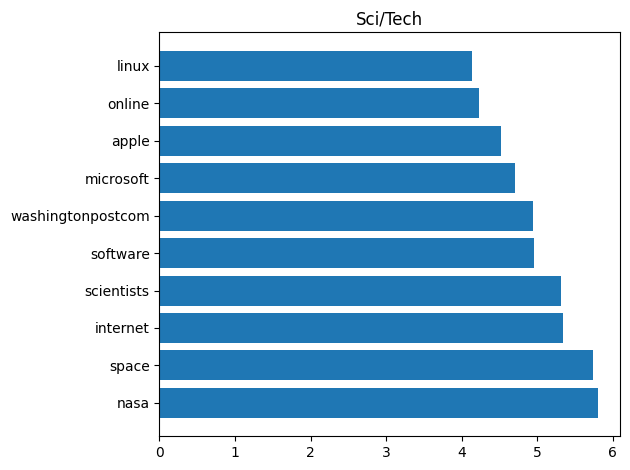

In [13]:
k = 10
coefs = log_reg.coef_
feature_names = vectorizer.get_feature_names_out() # TF-IDF map from coef to words

for i, class_name in enumerate(log_reg.classes_):
    class_coefs = coefs[i]
    top_idx = np.argsort(np.abs(class_coefs))[-k:][::-1]  # Top k indices
    top_features = [feature_names[j] for j in top_idx]
    top_coef =  [class_coefs[j] for j in top_idx]

    plt.barh(range(len(top_coef)), top_coef, tick_label = top_features)
    plt.title(labeler(class_name))
    plt.tight_layout()   
    plt.show()


Very cool! We see that some of these labels make a lot of sense.

## SVM
We will now implement a SVM classifier. Notice that, by default, TF-IDF data does not ask for scaling as norm is said to l2.

In [14]:
from sklearn.svm import SVC

best_val_error = -np.inf
best_c = np.inf
for c in [0.01, 0.1, 1, 10, 100]:
    svm_c = SVC(kernel = 'linear', C = c,  max_iter = 5000)

    svm_c.fit(X_train, y_train)
    val_error = svm_c.score(X_val, y_val)
    print(f'Validation error @{c:}: {val_error:.2f}')
    if val_error > best_val_error:
        best_val_error =  val_error
        best_c = c

/home/hlovisie/venvs/torch-cuda/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Validation error @0.01: 0.81


/home/hlovisie/venvs/torch-cuda/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Validation error @0.1: 0.89


/home/hlovisie/venvs/torch-cuda/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Validation error @1: 0.90


/home/hlovisie/venvs/torch-cuda/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Validation error @10: 0.84


/home/hlovisie/venvs/torch-cuda/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Validation error @100: 0.82


In [15]:
best_c

1

Coincidentely, best `C` is again 1. We will now save this model accuracy.

In [17]:
svm = SVC(kernel = 'linear', C = best_c,  max_iter = 5000)
svm.fit(X_train, y_train)
test_error_svm = svm.score(X_test, y_test)
print(f'Accuracy of SVM {test_error_svm: .2f}')

filename = 'best_models_ag_news.json'
with open(filename, "rb") as f:
    error_dic = json.load(f)
error_dic['SVM'] = test_error_svm

with open(filename, "w") as f:
    json.dump(error_dic, f, indent = 2)

/home/hlovisie/venvs/torch-cuda/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy of SVM  0.90


## Multilayer perceptron
As of now, we have only tried linear models on the TF-IDF dataset, but it might be interesting to try some non-linear ones. One of the nicest implementations of non-linear models, especially at such a large space dimension, is MLP. So, we will try those. We will basically adapt the code of Day 3.

In [10]:
from torch.utils.data import Dataset
class NewsDataset(Dataset):
    def __init__(self):
        self.train_df = (X_train, y_train)
        self.train_size = X_train.shape[0]

        self.val_df = (X_val, y_val)
        self.val_size = X_val.shape[0]

        self.test_df = (X_test, y_test)
        self.test_size = X_test.shape[0]

        self._lookup_dict = {
            'train' : (self.train_df, self.train_size),
            'val' : (self.val_df, self.val_size),
            'test' : (self.test_df, self.test_size) 
        }

        self.set_split('train') 


    def set_split(self, split):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]
    
    def __len__(self):
        return self._target_size
    
    def __getitem__(self, index):
        '''
        This basically allows one to iterate over the rows of the csv.
        '''
        return {
            'x_data': self._target_df[0][index].toarray(),
            'y_data': self._target_df[1][index],
            }
    
    def get_num_batches(self, batch_size):
        '''
        Returns the number of batches needed for that particular batch size.
        '''
        return len(self)//batch_size

In [11]:
news_pt = NewsDataset()
print(news_pt[0])

{'x_data': array([[0., 0., 0., ..., 0., 0., 0.]], shape=(1, 10000)), 'y_data': 1}


Great, let us define the collator.

In [12]:
from torch.utils.data import DataLoader

def generate_batches(dataset, batch_size, shuffle = True,
                     drop_last = True, device = "cpu"):
    dataloader = DataLoader(dataset = dataset, batch_size = batch_size,
                            shuffle = shuffle, drop_last = drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, _ in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

and the model

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_dimension, dropout_prob = 0.5, n_class = 4):
        super().__init__() 
        self.fc1 = nn.Linear(input_size, hidden_dimension)
        self.fc2 = nn.Linear(hidden_dimension, n_class)
        self.dropout = nn.Dropout(p = dropout_prob)
        self.input_size = input_size
    
    def forward(self, x_in):
        if x_in.shape[-1] != self.input_size:
            print(x_in.shape)
            raise Exception("Input dimension of the object must be equal to the model's expected diemension!") 
        intermediate = F.relu(self.fc1(x_in))
        # Add dropout
        intermediate = self.dropout(intermediate)
        y_out = self.fc2(intermediate)
        return y_out

Let us implement early stop.

In [14]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience = 5, min_delta = 0, save = None):
        self.patience = patience
        self.min_delta = min_delta
        self.save = save
        self.best_loss = np.inf
        self.patience_counter = 0
        self.flag = False
    
    def __call__(self, val_loss, model = None):
        # If the validation loss improved, we basically 
        # update the new best lost and save the model
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.patience_counter = 0
        
            if (self.save) and (model is not None):
                torch.save(model.state_dict(), self.save)
        
        else:
            self.patience_counter += 1
            if self.patience_counter > self.patience:
                self.flag = True

        

And, finally, the training loop.

In [17]:
from sklearn.metrics import accuracy_score, f1_score
from torch.optim.lr_scheduler import StepLR

lr = 1e-3
hidden_dimension = 256
n_epochs = 100
loss_fn = nn.CrossEntropyLoss()
batch_size = 128
# Allows for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

classifier = MLP(10000, hidden_dimension, 0.5)
classifier.to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr = 1e-3)
# Multiplies the learning rate by `gamma` every `step_size` epoch
scheduler = StepLR(optimizer, step_size = 5, gamma = 0.1)

early_stopping = EarlyStopping(min_delta = 0.001, save = 'best_mlp_model_ag_news.pt')

for epoch in range(n_epochs): 
    news_pt.set_split('train')
    batch_generator = generate_batches(news_pt, batch_size = batch_size, device = device)
    running_loss = 0.
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        # 1. Zero the gradient
        classifier.zero_grad()

        # 2. Prediction
        y_pred = classifier(x_in = batch_dict['x_data'].float())

        # 3. Compute loss
        # Needs to subtract 1 because CUDA assumes labels in [0,3]
        loss = loss_fn(y_pred.squeeze(), (batch_dict['y_data'] - 1).long())
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)


        # 4. Backpropagate
        loss.backward()
        
        # 5. Optimize
        optimizer.step()

    # Evaluation part, we don't want paramereres to change
    classifier.eval()
    news_pt.set_split('val')
    
    # Will be used to store predictions, as F1 can only
    # be computed at the end (no running F1)
    all_preds = []
    all_labels = []

    batch_generator = generate_batches(news_pt, batch_size = batch_size, device = device)
    for _, batch_dict in enumerate(batch_generator):
        with torch.no_grad(): # Avoids backpropagation
            all_preds.append(classifier(x_in = batch_dict['x_data'].float()).cpu())
            all_labels.append((batch_dict['y_data'] - 1).long().cpu())
            
    # Computes metrics
    all_labels, all_preds = torch.cat(all_labels), torch.cat(all_preds).squeeze()
    val_loss = loss_fn(all_preds, all_labels)
    # For computing accuracy and F1, we need the variables as binary
    all_preds = torch.argmax(all_preds, dim=1)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average = 'macro')

    # Updates early stop
    early_stopping(val_loss, classifier)
    if early_stopping.flag:
        print('Early stopped at epoch:', epoch)
        break

    # Updates scheduler
    scheduler.step()

    print('Epoch: ', epoch)
    print('Training loss', running_loss)
    print('Validation loss', val_loss.item())
    print('Validation accuracy: ', acc)
    print('Validation F1: ', f1)

Epoch:  0
Training loss 0.40950503789798803
Validation loss 0.2743649184703827
Validation accuracy:  0.9058299731182796
Validation F1:  0.9053025615373511
Epoch:  1
Training loss 0.23273977368610452
Validation loss 0.2702327370643616
Validation accuracy:  0.9056619623655914
Validation F1:  0.9051915752023176
Epoch:  2
Training loss 0.19064196722398585
Validation loss 0.2786482870578766
Validation accuracy:  0.9037298387096774
Validation F1:  0.903326150506718
Epoch:  3
Training loss 0.1603223755248644
Validation loss 0.28910377621650696
Validation accuracy:  0.901377688172043
Validation F1:  0.9009301883692459
Epoch:  4
Training loss 0.13373570714238722
Validation loss 0.30707237124443054
Validation accuracy:  0.9009576612903226
Validation F1:  0.9005607551997075
Epoch:  5
Training loss 0.09933418919987454
Validation loss 0.3122294843196869
Validation accuracy:  0.9017137096774194
Validation F1:  0.901318079693167
Epoch:  6
Training loss 0.09585303413070738
Validation loss 0.3157963454

Great, we even saw some overfitting. Let us see how test accuracy looks like.

In [18]:
classifier.load_state_dict(torch.load("best_mlp_model_ag_news.pt"))
classifier.eval()

MLP(
  (fc1): Linear(in_features=10000, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [19]:
news_pt.set_split('test')
    
# Will be used to store predictions, as F1 can only
# be computed at the end (no running F1)
all_preds = []
all_labels = []

batch_generator = generate_batches(news_pt, batch_size = batch_size, device = device)
for _, batch_dict in enumerate(batch_generator):
    with torch.no_grad(): # Avoids backpropagation
        all_preds.append(classifier(x_in = batch_dict['x_data'].float()).cpu())
        all_labels.append((batch_dict['y_data'] - 1).long().cpu())
        
# Computes metrics
all_labels, all_preds = torch.cat(all_labels), torch.cat(all_preds).squeeze()
val_loss = loss_fn(all_preds, all_labels)
# For computing accuracy and F1, we need the variables as binary
all_preds = torch.argmax(all_preds, dim=1)
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average = 'macro')

print('Validation accuracy: ', acc)
print('Validation F1: ', f1)

Validation accuracy:  0.9033368644067796
Validation F1:  0.9032067271417609


Not bad, but not much better than logistic regression. This is somewhat expected, as the literature indicates that TF-IDF leads to very linearly seperable embeddings! Still, let us save it in our dictionary.

In [21]:
import json
filename = 'best_models_ag_news.json'
with open(filename, "rb") as f:
    error_dic = json.load(f)
error_dic['MLP'] = acc

print(error_dic)

with open(filename, "w") as f:
    json.dump(error_dic, f, indent = 2)

{'Logistic Regression': 0.9002631578947369, 'SVM': 0.8967105263157895, 'MLP': 0.9033368644067796}


# Transformer

We have explored TF-IDF to its maximum quality on this datatset, so let us move to stronger models. We will now use a transformer model for both feature extraction and fine-tuning and we will see if this model beats the other approaches. We will be using my favorite model: distilled BERT!

In [1]:
model_ckpt = 'distilbert-base-uncased'

We will follow the strategy of Day 4, that is, using both a feature extraction model (with a logistic regression head) and fine-tune BERT. I will reload the dataset, as we shall not validate from now on.

In [2]:
from datasets import load_dataset
news = load_dataset('sh0416/ag_news')

/home/hlovisie/venvs/torch-cuda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Feature extraction

We start tokenizing the data.

In [49]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
def tokenize(example):
    return tokenizer(example['description'], padding = True, truncation = True)
encoded_news = news.map(tokenize, batched = True) 
encoded_news.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Let us test

In [9]:
some_news = encoded_news['train']['input_ids'][0]
print('Original text:', news['train']['description'][0])
print('Converted text:', tokenizer.convert_ids_to_tokens(some_news))

Original text:  BESLAN, Russia (Reuters) - The killing of more than 320  children, parents and teachers during the bloody end to a  53-hour school siege left barely a family untouched in the  small Russian town of Beslan.
Converted text: ['[CLS]', 'be', '##sl', '##an', ',', 'russia', '(', 'reuters', ')', '-', 'the', 'killing', 'of', 'more', 'than', '320', 'children', ',', 'parents', 'and', 'teachers', 'during', 'the', 'bloody', 'end', 'to', 'a', '53', '-', 'hour', 'school', 'siege', 'left', 'barely', 'a', 'family', 'untouched', 'in', 'the', 'small', 'russian', 'town', 'of', 'be', '##sl', '##an', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

Seems all good! Let us extract features!

In [10]:
from transformers import AutoModel
import torch 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModel.from_pretrained(model_ckpt).to(device)

So, this, for some reason, created some lists for attention masks instead of tensors. I tried to debug for some hours, but then I realized that the set of problematic batches is very very small, so I'll just ignore these cases, although we keep track of their percentage.

In [56]:
batch_problems = {'count': 0, 'total_batches': 0}

def extract_hidden_states(batch):
    batch_problems['total_batches'] += 1
    try:
        inputs = {k:v.to(device) for k,v in batch.items()
                if k in tokenizer.model_input_names}
        with torch.no_grad():
            last_hidden_state = model(**inputs).last_hidden_state
        # To use map, we need tensors in numpy
        return {'hidden_state': last_hidden_state[:,0].cpu().numpy()}
    except:
        batch_problems['count'] += 1
        return None

hidden = encoded_news.map(
    extract_hidden_states,
    batched=True,
    batch_size=64,      
)

Map: 100%|██████████| 7600/7600 [00:56<00:00, 134.47 examples/s]


In [58]:
100*batch_problems['count']/batch_problems['total_batches']

5.513784461152882

So, indeed, only 6% of the batches are problematic.

Now let us train a logistic regression model.

In [63]:
import numpy as np

X_train = np.array(hidden['train']['hidden_state'])
X_test = np.array(hidden['test']['hidden_state'])
y_train = np.array(hidden['train']['label'])
y_test = np.array(hidden['test']['label'])

from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
log.fit(X_train, y_train)

/tmp/ipykernel_25851/4121443623.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  X_train = np.array(hidden['train']['hidden_state'])
/tmp/ipykernel_25851/4121443623.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  X_test = np.array(hidden['test']['hidden_state'])
/tmp/ipykernel_25851/4121443623.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. T

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


Let us check

In [66]:
feature_error = log.score(X_test, y_test)
print(feature_error)

0.9005872483221476


It seems that BERT-encoding only does not do much better than TF-IDF. Let us save it.

In [67]:
import json
filename = 'best_models_ag_news.json'
with open(filename, "rb") as f:
    error_dic = json.load(f)
error_dic['Feature Extraction'] = feature_error
print(error_dic)

with open(filename, "w") as f:
    json.dump(error_dic, f, indent = 2)

{'Logistic Regression': 0.9002631578947369, 'SVM': 0.8967105263157895, 'MLP': 0.9033368644067796, 'Feature Extraction': 0.9005872483221476}


## Fine-tuning
We will now fine tune BERT for our particular problem. We first tokenize.

In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
def tokenize(example):
    return tokenizer(example['description'], padding = True, truncation = True)
encoded_news = news.map(tokenize, batched = True) 
encoded_news.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Now we define the trainer.I will only do one epoch as the dataset is really big for my GPU.

In [4]:
from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer

import torch 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average = 'weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}


from transformers import AutoModelForSequenceClassification
import transformers

num_labels = 4
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = num_labels).to(device)

# Again, labels need to be 0,..,3
def fix_labels(example):
    example['label'] = example['label'] - 1  # if original labels are 1..4
    return example

encoded_news = encoded_news.map(fix_labels)

batch_size = 32
# Controls how often the training metrics are updated, that is, once per batch
logging_steps = len(encoded_news['train'])//batch_size
model_name = f"{model_ckpt}-finetuned"
training_args = transformers.TrainingArguments(output_dir = model_name,
                                num_train_epochs = 1,
                                learning_rate = 2e-5,
                                per_device_train_batch_size = batch_size,
                                per_device_eval_batch_size = batch_size,
                                weight_decay = 0.01,
                                disable_tqdm = False, # Allow to show progress bars
                                logging_steps = logging_steps,
                                log_level = 'error') # Verbosity level
   
trainer = Trainer(model = model, 
                  args = training_args,
                  compute_metrics = compute_metrics,
                  train_dataset = encoded_news['train'],
                  tokenizer = tokenizer)
trainer.train() 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 7600/7600 [00:01<00:00, 5560.24 examples/s]
/tmp/ipykernel_32062/1522911100.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model = model,


Step,Training Loss
3750,0.242500


TrainOutput(global_step=3750, training_loss=0.242492919921875, metrics={'train_runtime': 4134.6236, 'train_samples_per_second': 29.023, 'train_steps_per_second': 0.907, 'total_flos': 1.0999549542100224e+16, 'train_loss': 0.242492919921875, 'epoch': 1.0})

In [5]:
pred_output = trainer.predict(encoded_news['test'])
pred_output.metrics

{'test_loss': 0.18979044258594513,
 'test_accuracy': 0.9336842105263158,
 'test_f1': 0.9336776216228229,
 'test_runtime': 67.7163,
 'test_samples_per_second': 112.233,
 'test_steps_per_second': 3.515}

Very nice improvement for just one epoch. Let us compare all methods finally.

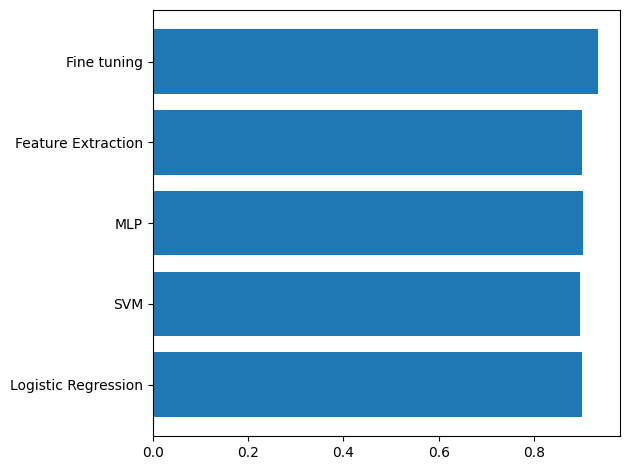

In [8]:
import matplotlib.pyplot as plt
import json
filename = 'best_models_ag_news.json'
with open(filename, "rb") as f:
    error_dic = json.load(f)
error_dic['Fine tuning'] = pred_output.metrics['test_accuracy']

models = error_dic.keys()
accs = error_dic.values()

plt.barh(range(len(accs)), accs, tick_label = models)
plt.tight_layout()   
plt.show()